In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

import scipy.io
import math


In [2]:
from google.colab import drive

drive.mount('/content/drive')

%pwd
%cd "/content/drive/MyDrive/Colab Notebooks/Red_Neuronal"
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Red_Neuronal


'/content/drive/MyDrive/Colab Notebooks/Red_Neuronal'

In [3]:
from RandParametros import randParametros
from fming import fmincg
from organizarBeta import organizarBeta


In [4]:
mat = scipy.io.loadmat('datos4.mat')
x_data = mat['X'];
y_data = mat['y'];
#print(x_data[0,:])

[9]


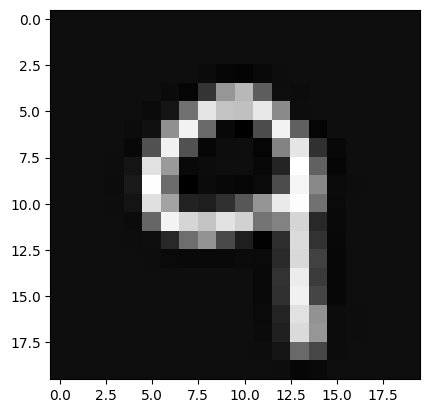

In [5]:
cont = 0
DatSetImage = np.zeros((20,20))
ImageNumber = 4850

for i in range(20):
  for j in range(20):
    DatSetImage[j,i] = x_data[ImageNumber,cont]
    cont+=1

plt.imshow(DatSetImage,cmap='gray')
print(y_data[ImageNumber])

In [6]:
#Dividir datos en Entrenamiento en 70% y 30%

x_dat_70 = [] #creamos auxiliares para realizar la separacion.
y_dat_70 = []

for i in range(0, 5000, 500): # aca le indicamos que vaya de 500 en 500
    x_dat70 = x_data[i:i+350, :] # le indicamos que tome solo una parte de los 500 y deje 350
    x_dat_70.append(x_dat70)
    y_dat70 = y_data[i:i+350, :]
    y_dat_70.append(y_dat70)

x_data_70 = np.concatenate(x_dat_70, axis=0) # concatenamos la informacion separada en los auxiliares
y_data_70 = np.concatenate(y_dat_70, axis=0)

x_data_30 = np.zeros((1500, 400))
y_data_30 = np.zeros((1500, 1))
posicion = 0

for j in range(500, 5500, 500):
  x_dat30 = x_data[j-150:j, :]#aca le indicamos que los 150 datos que separamos anteriormente los guarde
  x_data_30[posicion:posicion+150, :] = x_dat30
  y_dat30 = y_data[j-150:j, :]
  y_data_30[posicion:posicion+150, :] = y_dat30
  posicion += 150

#Calcular la m a partir de x_data_30

In [7]:
#validamos la separacion haya sido exitosa
print(y_data[600,0])
print(y_data_70[599,0])
print(y_data_30[459,0])

1
1
3.0


[10]


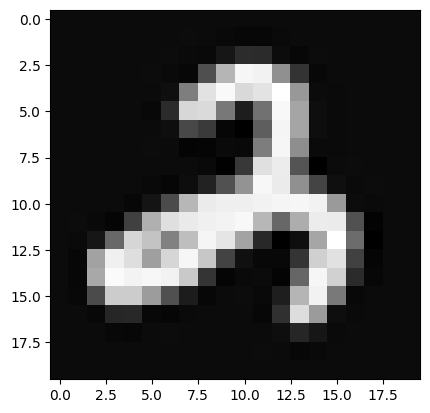

In [8]:
#validamos la imagen pero con la informacion que ya esta separada
cont = 0
DatSetImage = np.zeros((20,20))
ImageNumber = 350

for i in range(20):
  for j in range(20):
    DatSetImage[j,i] = x_data_30[ImageNumber,cont]
    cont+=1

plt.imshow(DatSetImage,cmap='gray')
print(y_data[ImageNumber])

In [9]:
Beta1_grad = 0;
Beta2_grad = 0;

tamano_capa_entrada  = 400;
tamano_capa_media = 25;
num_salidas =  10;

In [10]:
Beta1_inicial = randParametros(tamano_capa_entrada,tamano_capa_media);
Beta2_inicial = randParametros(tamano_capa_media, num_salidas);
parametros_Beta_Iniciales = np.concatenate((Beta1_inicial, Beta2_inicial),axis=None)
#print(parametros_Beta_Iniciales)
parametros_Beta_Iniciales = np.reshape(parametros_Beta_Iniciales,(parametros_Beta_Iniciales.shape[0],))
#print(parametros_Beta_Iniciales)

In [11]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Iniciales)

In [12]:
#Esta celda debe ser finalizada
def nnFunction1(nn_params,tamano_capa_entrada,tamano_capa_media,num_salidas, x, y, Lambda,m):

    [Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,nn_params)
    dataSize = x_data_70.shape
    m = dataSize[0]
    J1 = 0 #variables auxiliares para realizar el calculo
    Sum1 = 0
    Sum2=0
    acum1 = 0
    acum2 = 0

    for t in range(m):
        #Propagacion hacia adelante
        X = x_data_70[t,:]  #(400,1)
        a1 = np.concatenate((1,X), axis = None) #la matriz nos queda de (401,)
        a1 = np.reshape(a1,(401,1)) #convierte la matriz de (401,) a (401,1)
        z2 = np.dot(Beta1,a1) #(25,401) multiplica Beta1 con la transpuesta de a1
        g2 = 1/(1+(1/np.exp(z2))) #funcion g(z)
        a2 = np.concatenate((1,g2[:,0]), axis = None) # trabajos en la capa 2
        a2 = np.reshape(a2,(26,1))
        z3 = np.dot(Beta2, a2)
        g3 = 1/(1+(1/np.exp(z3)))
        a3 = g3

        #Paso intermedio
        vectoraux = int(y_data_70[t])
        Yout = np.zeros((10,1))
        Yout[vectoraux-1] = 1

        #Propagacion hacia atras

        gradsigZ2 = np.multiply(g2, (1 - g2)) #(25,1)
        delta3 = (a3 - Yout) #(10,1)
        delta2 = np.multiply(np.dot(np.transpose(Beta2[:,1:]),delta3),gradsigZ2)

        #Acumuladores

        acum1 = acum1 + np.dot(a1, np.transpose(delta2)) #la trasponemos para regresar al tamaño original
        acum2 = acum2 + np.dot(a2,np.transpose(delta3))


        #Funcion cost(J) parte 1
        J1= J1 + np.sum(np.multiply(Yout, np.log(a3)) + np.multiply((1 - Yout), np.log(1-a3)))

    #Funcion cost(J) parte 2
    Sum1=np.sum(np.power(Beta1[:,1:],2)) #hacemos las sumatorias por separado para reducir la exprecion de la operacion
    Sum2=np.sum(np.power(Beta2[:,1:],2))
    J=(-1/m)*J1+(Lambda/(2*m))*(Sum1+Sum2)



    #Calculamos gradientes
    TempBeta1=Beta1 # creamos temporales para guardar los datos
    TempBeta2=Beta2
    TempBeta1[:,0]=0
    TempBeta2[:,0]=0
    Beta1_grad = np.multiply((1/m),(np.transpose(acum1)+np.multiply(Lambda,TempBeta1)))
    Beta2_grad = np.multiply((1/m),(np.transpose(acum2)+np.multiply(Lambda,TempBeta2)))

    grad = np.concatenate((Beta1_grad,Beta2_grad),axis=None)
    #tam = grad.size
    #grad.resize(tam,1)
    retornar = [J,grad]
    return retornar

In [13]:
#Celda de prueba
m=0
Lambda = 0.1
retornar = nnFunction1(parametros_Beta_Iniciales,tamano_capa_entrada,tamano_capa_media,num_salidas, x_data,y_data, Lambda, m)

In [14]:
def costFuncition(p):
    ret = nnFunction1(p,tamano_capa_entrada,tamano_capa_media,num_salidas,x_data_70,y_data_70,Lambda,m)
    return ret

In [18]:
options = {'maxiter' : 15}
Lambda = 0.1
parametros_Beta_Finales = fmincg(costFuncition,parametros_Beta_Iniciales,options)

Iteration 1 | Cost: 3.250244 
Iteration 2 | Cost: 3.218904 
Iteration 3 | Cost: 2.993333 
Iteration 4 | Cost: 2.701439 
Iteration 5 | Cost: 2.364523 
Iteration 6 | Cost: 2.060441 
Iteration 7 | Cost: 1.768814 
Iteration 8 | Cost: 1.618154 
Iteration 9 | Cost: 1.427511 
Iteration 10 | Cost: 1.363472 
Iteration 11 | Cost: 1.266823 
Iteration 12 | Cost: 1.207688 
Iteration 13 | Cost: 1.164348 
Iteration 14 | Cost: 1.067884 
Iteration 15 | Cost: 1.015193 


In [19]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Finales)
print(len(parametros_Beta_Finales))
print(Beta2)

3
[[-0.8942597   0.78919382 -0.36209919 -1.76316579  0.91927318  0.62232197
  -0.66239474 -0.14480805  0.85934651  0.794091   -1.32733091 -1.4235456
  -0.42628429 -1.87868584  0.50922119  0.1389135   0.83605735 -1.83352409
   1.47324999  0.1759561   1.07320959 -1.89464175 -0.11495802 -1.2649845
   0.01010574 -0.42391026]
 [-0.91184056  1.15832745 -2.06819361  0.56405906 -1.77493673 -0.88802286
  -1.67035604 -0.78789698 -0.91700266 -0.1756788  -1.35867819  0.27113374
   0.35412235 -1.15220643 -0.47017943  0.47609552 -1.20718794 -0.25573125
   0.02949891  0.91456561 -0.23983687 -0.33199122 -0.27024488  0.49863294
   0.75640673  0.29271243]
 [-0.74567346  0.8937836  -1.03842804 -1.72628088  0.27639629 -0.89249111
  -0.95389244  0.47387619  0.87393676 -0.60514787  0.88535975 -0.36876512
   1.03117891 -0.8675206  -0.74623953 -0.10415969 -0.78650304  0.26811764
  -0.81142466 -0.79695612 -0.91850318  0.09417491 -0.63974224 -1.39654011
  -0.39629711 -1.30120406]
 [-0.871632   -1.11113161 -0.70

In [20]:
#Cálcular Matriz de Confución con el 30% de los datos
#entrenamos la red neuronal con el 30% de datos separados
dataSize = x_data_30.shape
m = dataSize[0]
MC = np.zeros((10,10))
for t in range(m):
  X = x_data_30[t,:]  #(400,1)
  a1 = np.concatenate((1,X), axis = None) #(401,)
  a1 = np.reshape(a1,(401,1)) #convierte de (401,) a (401,1)
  z2 = np.dot(Beta1,a1) #(25,401) multiplica Beta1 con la transpuesta de a1
  g2 = 1/(1+(1/np.exp(z2))) #funcion g(z)
  a2 = np.concatenate((1,g2[:,0]), axis = None) #repetimos el paso anterior pero con la capa 2 de la red neuronal
  a2 = np.reshape(a2,(26,1))
  z3 = np.dot(Beta2, a2)
  g3 = 1/(1+(1/np.exp(z3)))
  a3 = g3
  clase_calculada = np.argmax(a3)
  MC[int(y_data_30[t])-1,int(clase_calculada)] = MC[int(y_data_30[t])-1,int(clase_calculada)] + 1

print(MC)


[[148.   0.   0.   0.   2.   0.   0.   0.   0.   0.]
 [  5. 119.   3.   8.   0.   2.   1.   6.   0.   6.]
 [  2.   3. 123.   1.  11.   0.   2.   7.   1.   0.]
 [  1.   2.   0. 135.   0.   5.   0.   1.   6.   0.]
 [  1.   0.  12.   5. 108.   2.   0.  15.   2.   5.]
 [  0.  12.   0.   2.   1. 131.   0.   2.   0.   2.]
 [  2.   3.   0.   3.   3.   0. 136.   0.   3.   0.]
 [  3.   8.   1.   1.   2.   2.   1. 128.   4.   0.]
 [  1.   2.   1.  17.   1.   0.  19.   1. 104.   4.]
 [  0.   0.   0.   0.   2.   2.   2.   0.   0. 144.]]
